# Decomposition And Embedding

## Purpose
The purpose of this step is to run PCA and manifold leanring (tSNE and UMAP) on the cell-by-feature matrix, feature to use can be either HVF or CEF. We use both the mCH and mCG matrix. We first run PCA on mCH and mCG matrix separately, and then concatenate mCH and mCG top PCs together to run KNN, followed by tSNE and UMAP embedding.

## Input
- HVF adata files.

## Output
- HVF adata file with PCA, tSNE and UMAP calculated.

## Import

In [1]:
import yaml
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import anndata

from ALLCools.clustering import tsne
from ALLCools.plot import *
from wmb import cemba

## Parameters

In [2]:
with open('config/05c.yaml', 'r') as f:
    config = yaml.safe_load(f)
    locals().update(config)
    print('Notebook configs:')
    for _k, _v in config.items():
        print(f'{_k} = {_v}')

Notebook configs:
cg_adata_path = mcg_adata.with_coords.h5ad
ch_adata_path = mch_adata.with_coords.h5ad
dataset = mC
pre_cluster_name = leiden


In [3]:
# Parameters
cg_adata_path = "mcg_adata.with_coords.h5ad"
ch_adata_path = "mch_adata.with_coords.h5ad"
dataset = "mC"
pre_cluster_name = "leiden"


## Load Data

In [4]:
if dataset == 'mC':
    metadata = cemba.get_mc_mapping_metric()
else:
    metadata = cemba.get_m3c_mapping_metric()

In [5]:
ch_adata = anndata.read_h5ad(ch_adata_path)
cg_adata = anndata.read_h5ad(cg_adata_path)

## Concatenate PCs

In [6]:
ch_pcs = ch_adata.obsm['X_pca']
cg_pcs = cg_adata.obsm['X_pca']

# scale the PCs so CH and CG PCs has the same total var
cg_pcs = cg_pcs / cg_pcs.std()
ch_pcs = ch_pcs / ch_pcs.std()

# total_pcs
total_pcs = np.hstack([ch_pcs, cg_pcs])

In [7]:
# make a copy of adata, add new pcs
# this is suboptimal, will change this when adata can combine layer and X in the future
adata = ch_adata.copy()

In [8]:
adata.obsm['X_pca'] = total_pcs.copy()
del adata.uns['pca']
del adata.varm['PCs']

## Plot

Red axis labels are used PCs


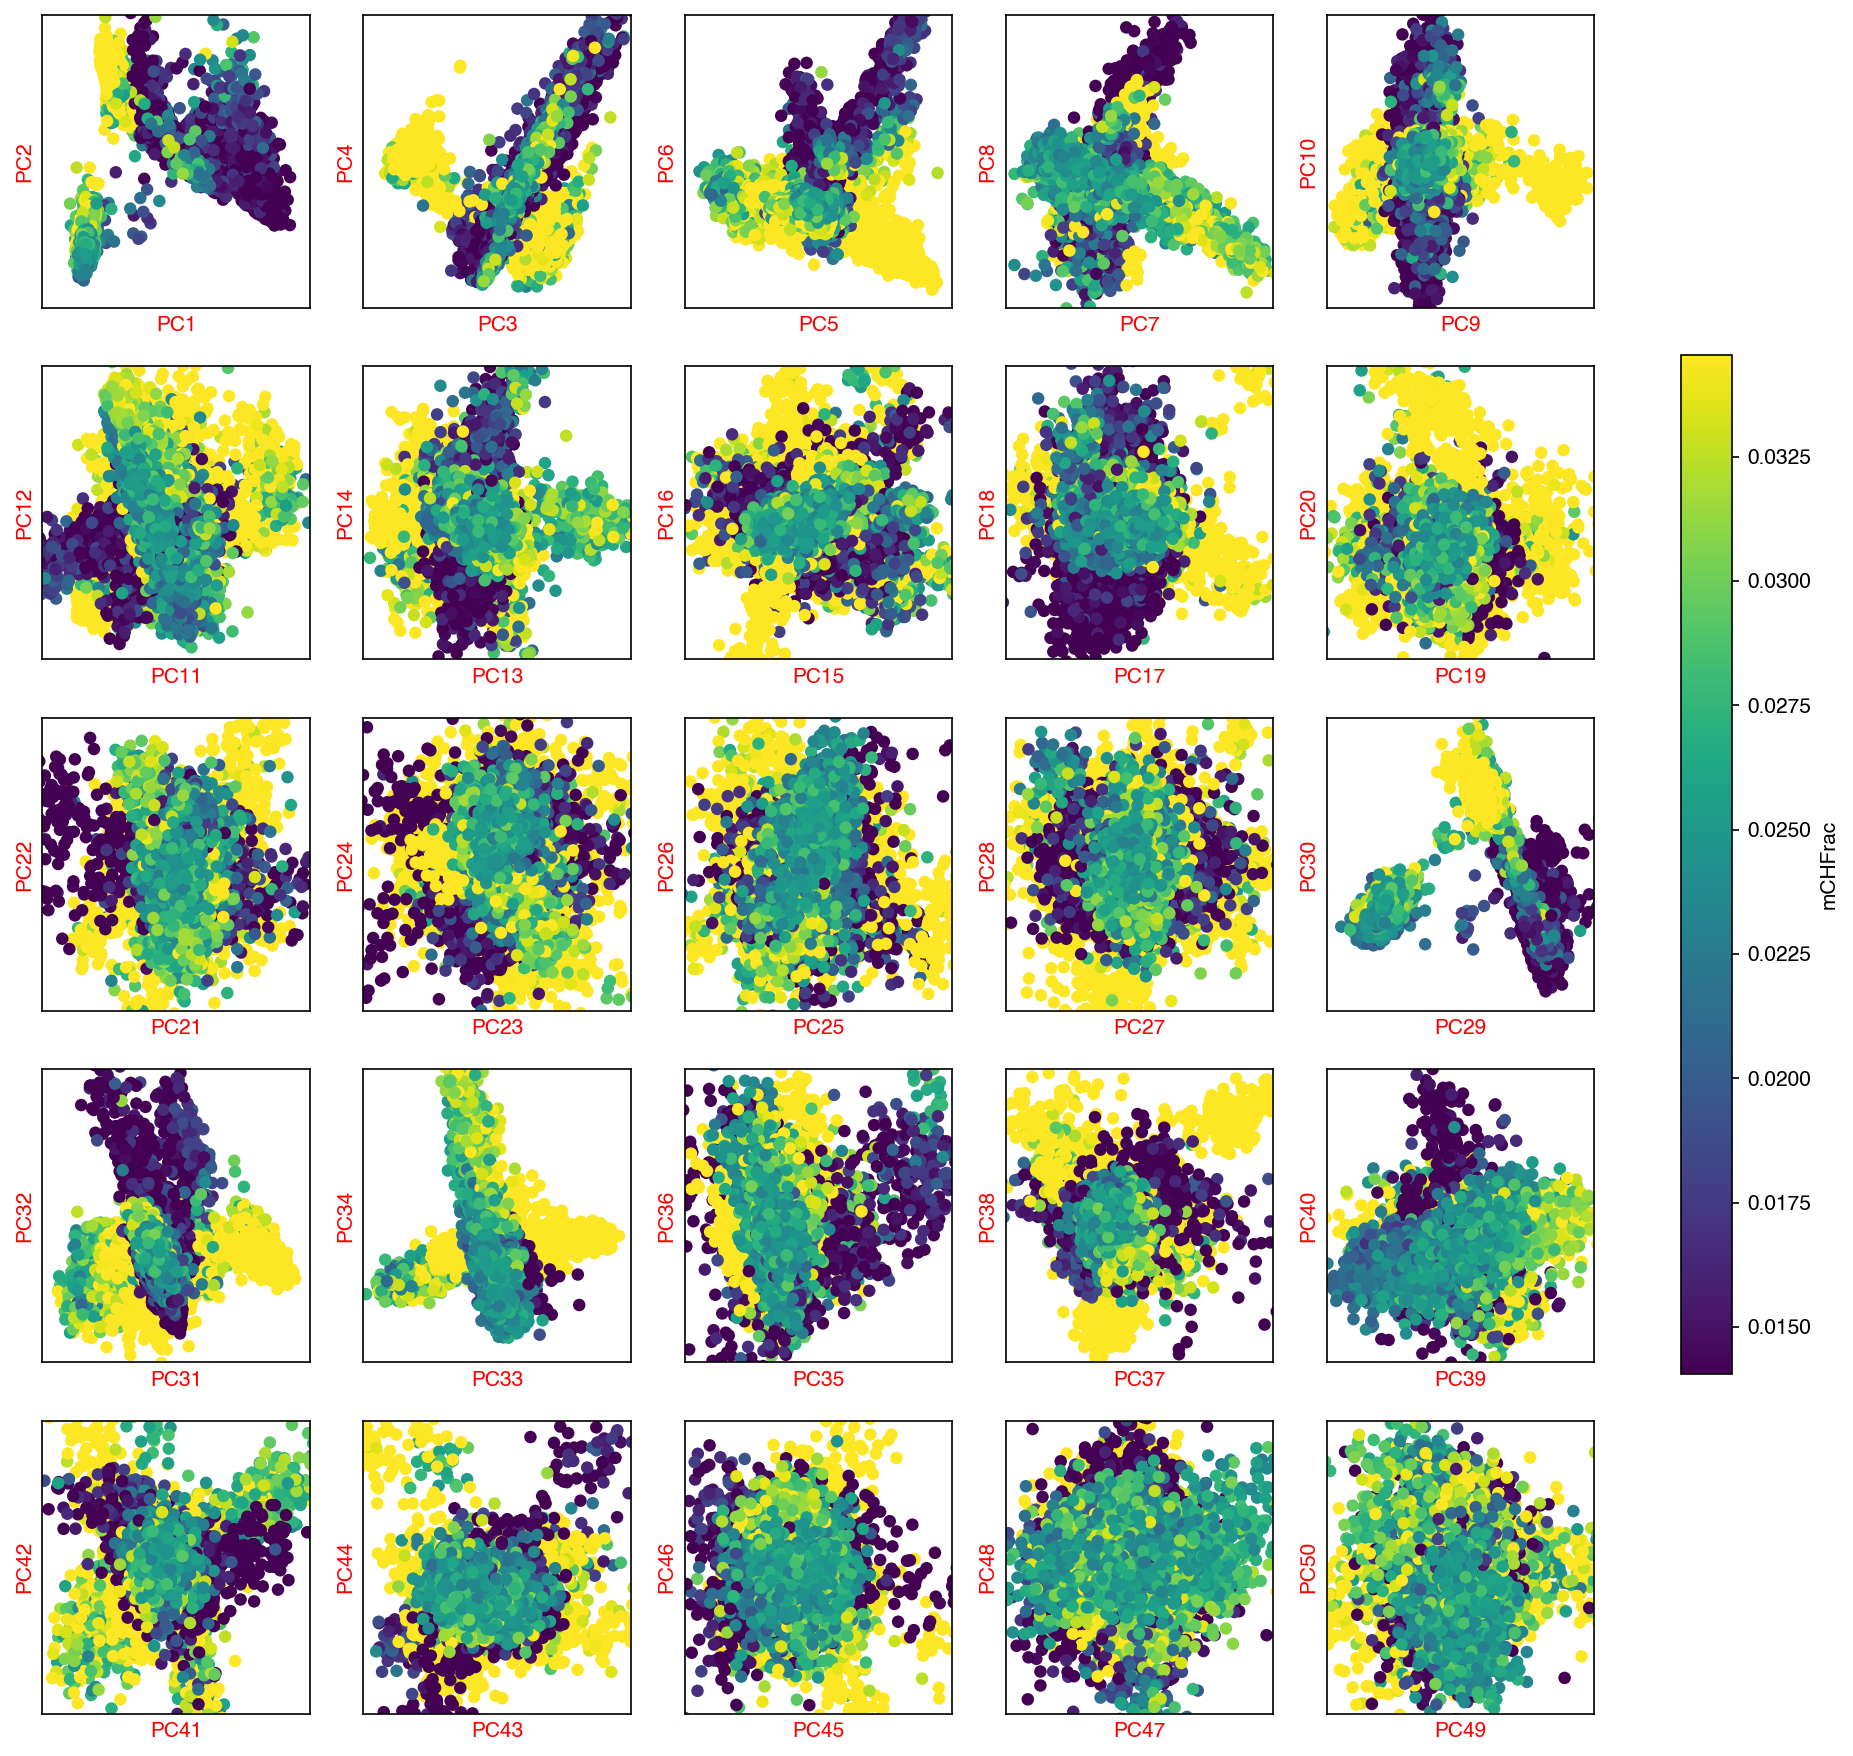

In [9]:
hue = 'mCHFrac'
if hue in metadata.columns:
    adata.obs[hue] = metadata[hue].reindex(adata.obs_names)
    fig, axes = plot_decomp_scatters(adata,
                                     n_components=adata.obsm['X_pca'].shape[1],
                                     hue=hue,
                                     hue_quantile=(0.25, 0.75),
                                     nrows=5,
                                     ncols=5)

Red axis labels are used PCs


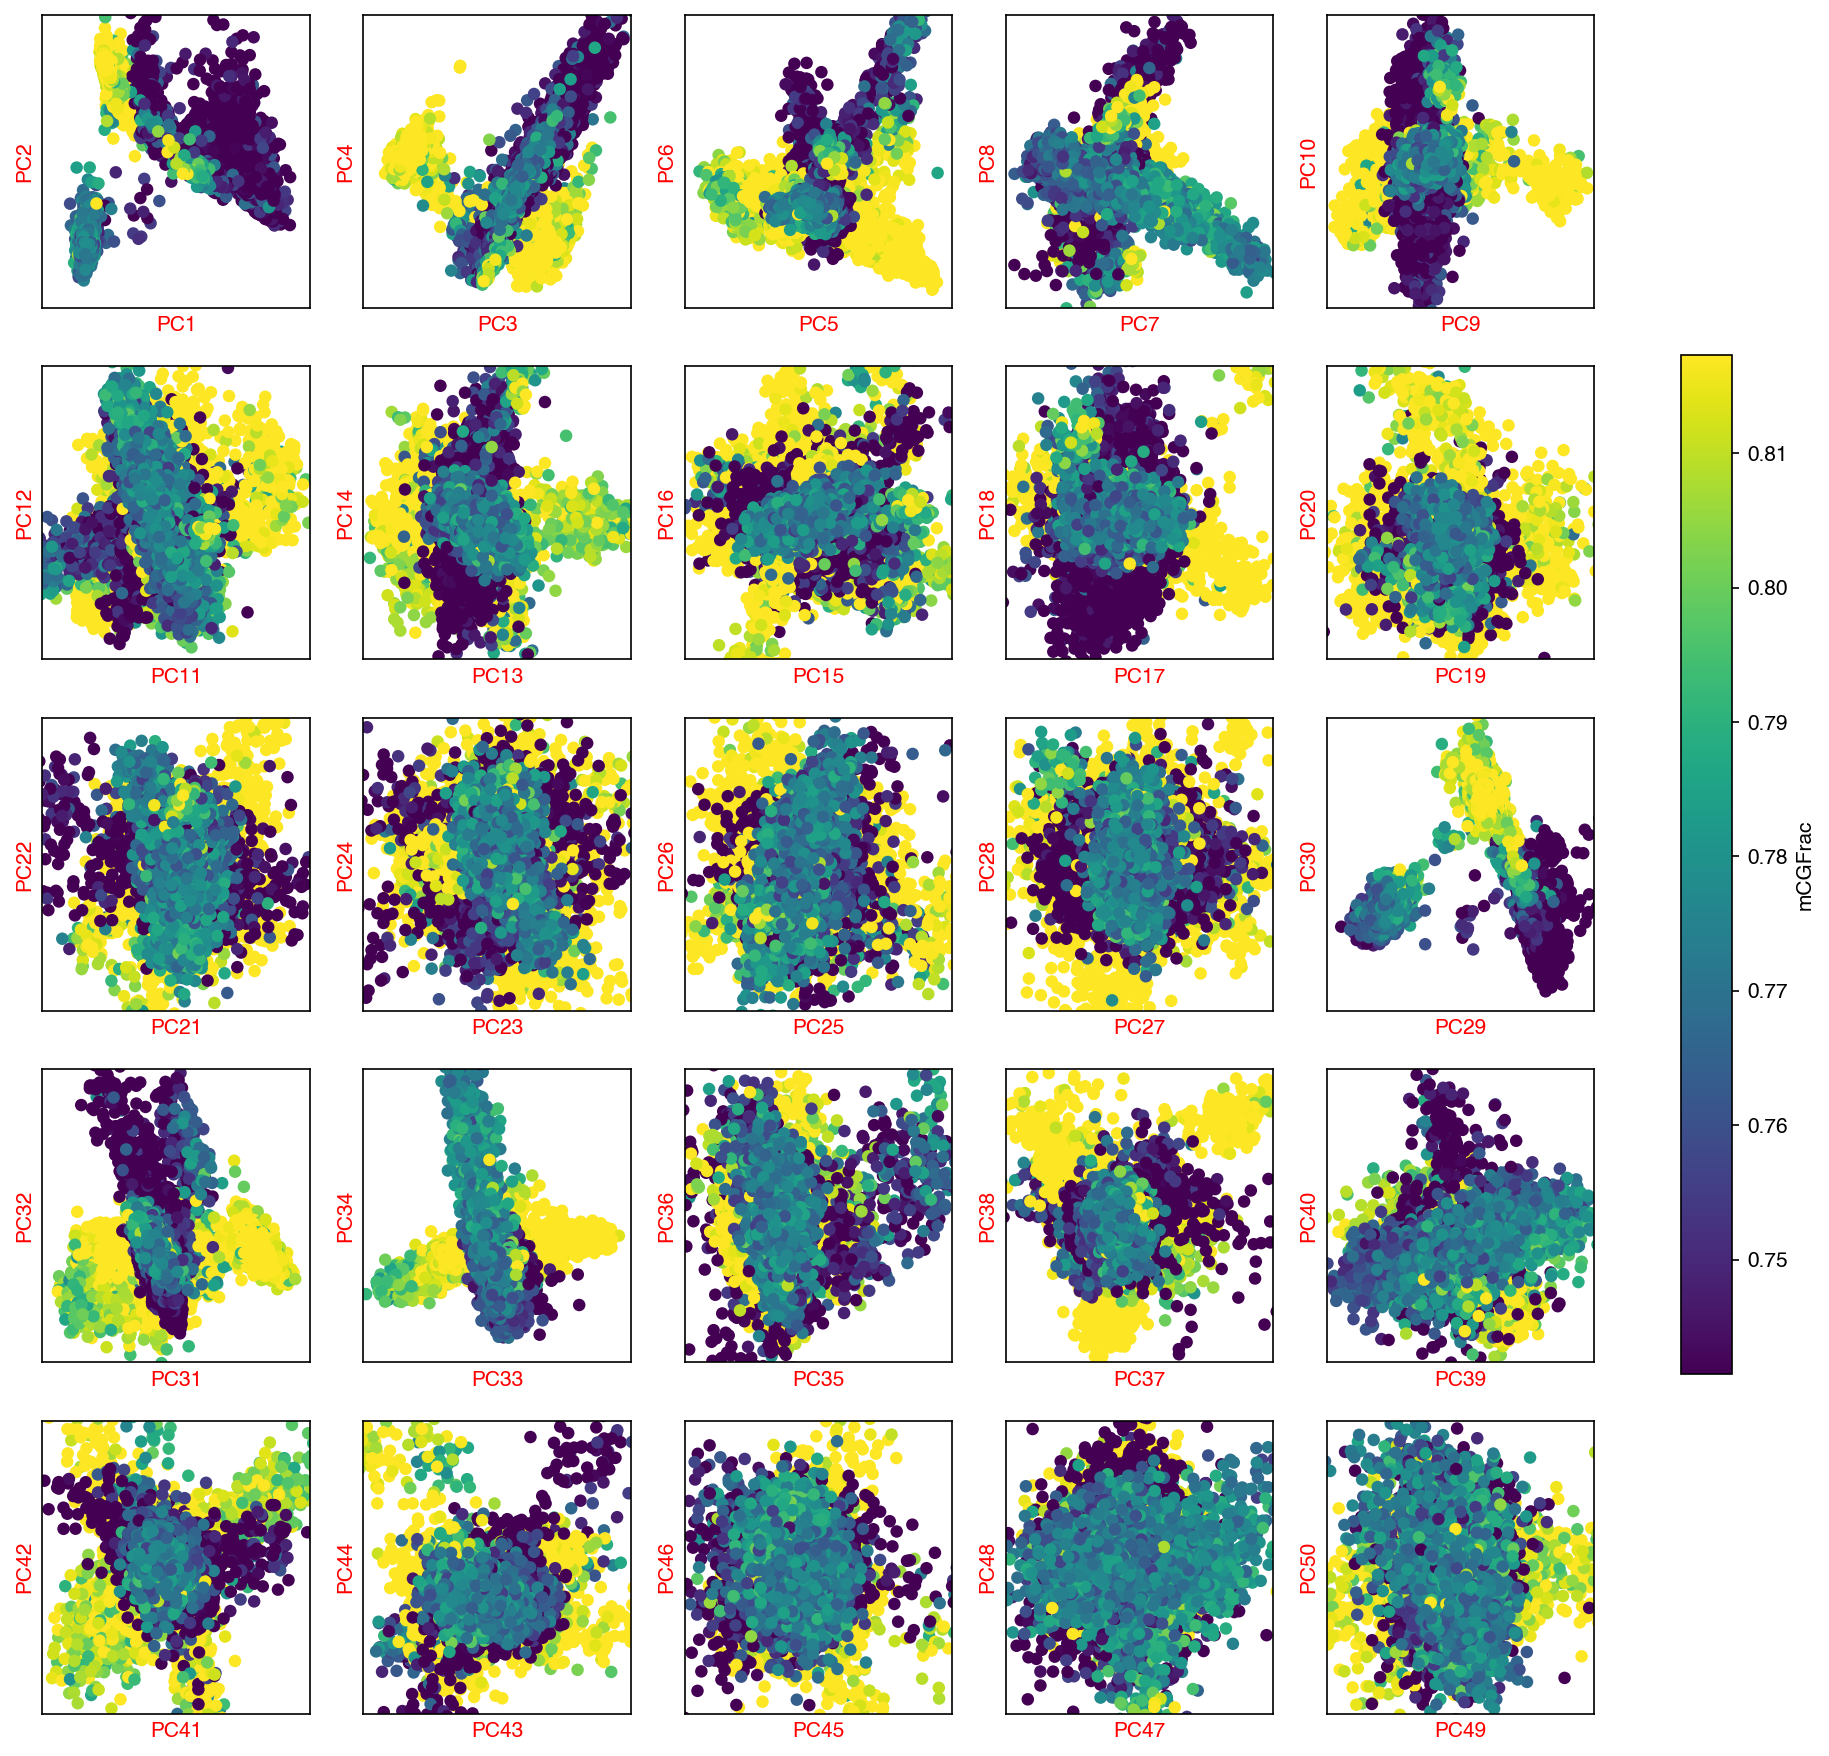

In [10]:
hue = 'mCGFrac'
if hue in metadata.columns:
    adata.obs[hue] = metadata[hue].reindex(adata.obs_names)
    fig, axes = plot_decomp_scatters(adata,
                                     n_components=adata.obsm['X_pca'].shape[1],
                                     hue=hue,
                                     hue_quantile=(0.25, 0.75),
                                     nrows=5,
                                     ncols=5)

## Manifold Learning

### tSNE

In [11]:
tsne(adata,
     obsm='X_pca',
     metric='euclidean',
     exaggeration=-1,  # auto determined
     perplexity=30,
     n_jobs=-1)

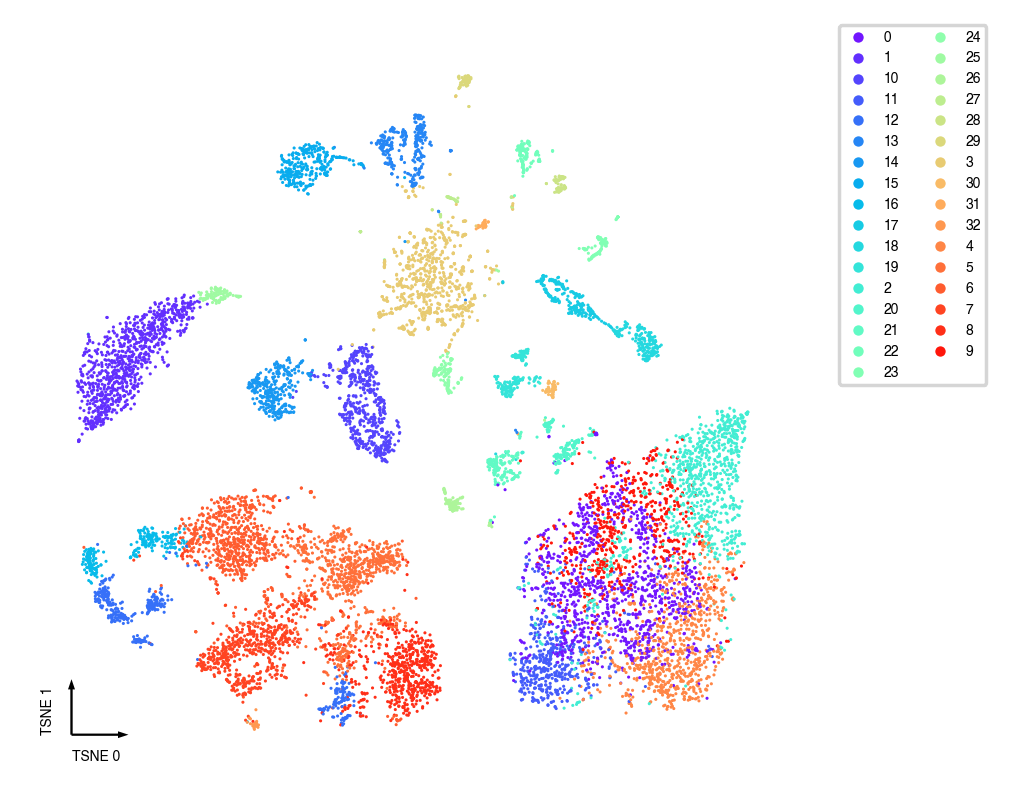

In [12]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=250)
categorical_scatter(data=adata,
                    ax=ax,
                    coord_base='tsne',
                    hue=pre_cluster_name,
                    show_legend=True,
                    max_points=None)

### UMAP

In [13]:
sc.pp.neighbors(adata)

min_dist = max(0.1, 1 - adata.shape[0] / 60000)
sc.tl.umap(adata, min_dist=min_dist)
min_dist

0.79515

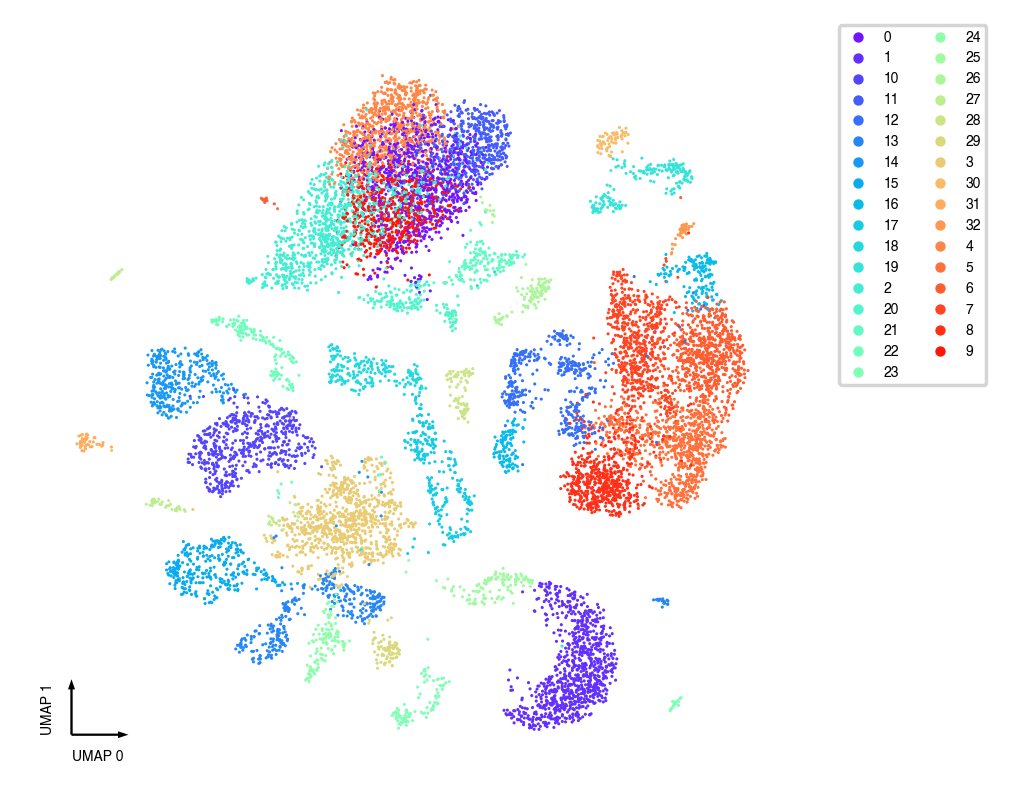

In [14]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=250)
categorical_scatter(data=adata,
                    ax=ax,
                    coord_base='umap',
                    hue=pre_cluster_name,
                    show_legend=True,
                    max_points=None)

## Save Results

In [15]:
adata.write_h5ad('adata.with_coords.h5ad')

adata

AnnData object with n_obs × n_vars = 12291 × 2244
    obs: 'leiden', 'mCHFrac', 'mCGFrac'
    var: 'chrom', 'cov_mean', 'end', 'start', 'CHN_feature_select', 'leiden_enriched_features'
    uns: 'leiden', 'leiden_feature_enrichment', 'log', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'distances', 'connectivities'